Testing out stuff for "increasing the granularity" -- Time-domain L-by-L samples broadcasting in DANSE
--> See Word journal week25 2022, MON.

In [38]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('default')  # <-- for Jupyter: white figures background

In [39]:
# Constants
N = 2**10       # FFT size (chunk length)
ovlp = .5       # frames overlap 
L = 16          # broadcast length
# L = 2**9          # broadcast length
Mk = 3          # number of channels
SEED = 12345    # random generator seed
fs = 16000      # sampling frequency [Hz]
T = 3 * N / fs          # duration [s]

In [40]:
# Other constants (indirect)
Ns = N * (1 - ovlp)

In [41]:
# Random generator
rng = np.random.default_rng(SEED)

# Generate a chunk of (real - time-domain) multichannel signal
yk = rng.random((int(T * fs), Mk))

# Generate a set of (complex - freq.-domain) filters -- only positive frequencies (`int(N / 2)`)
wkk = rng.random((int(N / 2 + 1), Mk)) + 1j * rng.random((int(N / 2 + 1), Mk))

In [42]:
# Process #1 - Freq. domain broadcasting
nChunks = int(T * fs // Ns)     # new chunk every `Ns` new samples

zkq_hat_posf = np.zeros((int(N / 2 + 1), nChunks), dtype=complex)
for l in range(nChunks):
    idxBeg = int(l * Ns)             # new chunk every `Ns` new samples
    idxEnd = int(idxBeg + N)
    ykl = yk[idxBeg:idxEnd, :]  # current data chunk (multichannel)

    # Go to freq. domain
    ykl_hat = np.fft.fft(ykl, N, axis=0)
    # Only keep positive frequencies
    ykl_hat_posf = ykl_hat[:int(N / 2 + 1), :]

    # Apply compression
    zk_hat_posf = np.einsum('ij,ij->i', wkk.conj(), ykl_hat_posf)

    # Broadcast
    zkq_hat_posf[:, l] = zk_hat_posf


# PLOT
chunksToPlot = [0, 10, 50]

# fig = plt.figure(figsize=(8,4))
# for ii in range(len(chunksToPlot)):
#     ax = fig.add_subplot(len(chunksToPlot) * 100 + 10 + ii + 1)
#     ax.plot(20 * np.log10(np.abs(zkq_hat_posf[:, chunksToPlot[ii]])))
#     ax.grid()
#     ax.set_title(f'Process #1 - $\\hat{{z}}_k$ Chunk #{chunksToPlot[ii] + 1}')
# plt.tight_layout()
# plt.show()

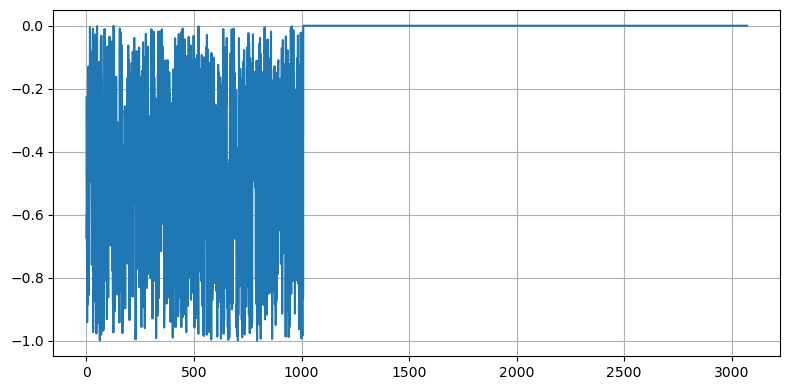

In [43]:
# Process #2 - Time domain broadcasting
nChunks = int(T * fs // L - 1)     # new chunk every `L` new samples

zk = np.zeros(yk.shape[0])
for l in range(nChunks):
    idxBeg = int(l * L)             # new chunk every `L` new samples
    idxEnd = int(idxBeg + N)
    if idxEnd > yk.shape[0]:
        break
    ykl = yk[idxBeg:idxEnd, :]  # current data chunk (multichannel)

    # Go to freq. domain
    ykl_hat = np.fft.fft(ykl, N, axis=0)
    # Only keep positive frequencies
    ykl_hat_posf = ykl_hat[:int(N / 2 + 1), :]

    # Apply compression
    # zk_hat_posf = np.einsum('ij,ij->i', wkk.conj(), ykl_hat_posf)
    zk_hat_posf = ykl_hat_posf[:, 0]

    # Complete frequency spectrum (with negative frequencies) before IFFT (see `back_to_time_domain()` function)
    zk_hat_posf = zk_hat_posf[:, np.newaxis]
    # zk_hat_posf[0, :] = zk_hat_posf[0, :].real      # Set DC to real value
    # zk_hat_posf[-1, :] = zk_hat_posf[-1, :].real    # Set Nyquist to real value
    zk_hat = np.concatenate((zk_hat_posf, np.flip(zk_hat_posf[:-1, :].conj(), axis=0)[:-1, :]), axis=0)
    # zk_hat = np.concatenate((np.flip(zk_hat_posf[:-1, :].conj(), axis=0)[:-1, :], zk_hat_posf), axis=0)

    # Go back to time domain
    zkl = np.fft.ifft(zk_hat, N, axis=0)
    zkl = np.real_if_close(zkl)

    # Extract the last `L` samples
    zkl_lastL = zkl[-L:]

    # Broadcast those
    zk[idxEnd-L:idxEnd] = np.squeeze(zkl_lastL)


fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)
ax.plot(zk - yk[:, 0])
ax.vlines([N, idxBeg])
ax.grid()
# ax.set_title(f'Process #1 - $\\hat{{z}}_k$ Chunk #{chunksToPlot[ii] + 1}')
plt.tight_layout()
plt.show()


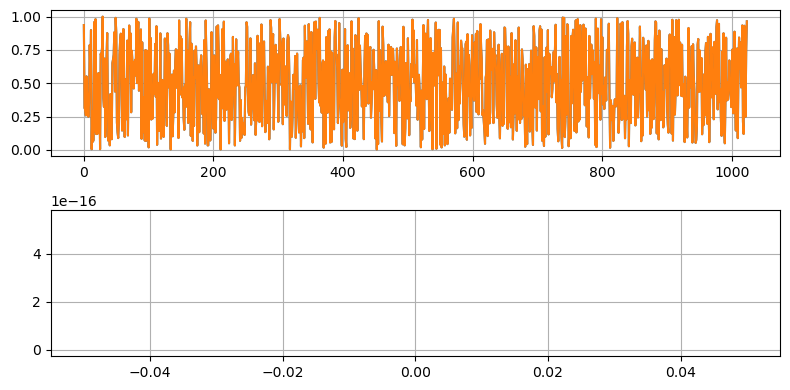

In [44]:

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(211)
ax.plot(zkl)
ax.plot(ykl[:,0])
ax.grid()
ax = fig.add_subplot(212)
ax.plot(np.abs(zkl.T - ykl[:,0]))
ax.grid()
plt.tight_layout()
plt.show()